# Importanciones

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [2]:
# filter warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Obtencion de datos y Preprocesado

In [4]:
def read_csv(file_path):
    return pd.read_csv(file_path)

In [5]:
def load_images_from_csv(csv_path, base_path):
    data = read_csv(csv_path)
    images = []
    labels = []
    
    for _, row in data.iterrows():
        img_path = row[1][1:]
        label = row[2]
        
        # Abrir la imagen
        with Image.open(img_path) as img:
            img = img.convert('L')  # Asegurarse de que esté en escala de grises
            images.append(np.array(img))
            labels.append(label)
    
    return images, labels


In [6]:
def normalize_images(images):
    return [img / 255.0 for img in images]

In [7]:
from sklearn.preprocessing import LabelEncoder

# Definir las emociones
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
label_encoder = LabelEncoder()
label_encoder.fit(emotions)

def encode_labels(labels):
    return label_encoder.transform(labels)


In [8]:
from tensorflow.keras.utils import to_categorical

def preprocess_labels(labels):
    numeric_labels = encode_labels(labels)
    return to_categorical(numeric_labels, num_classes=len(emotions))

In [9]:
def preprocess_data(images, labels):
    images = np.array(images, dtype=np.float32)
    labels = preprocess_labels(labels)
    
    # Normalizar las imágenes
    images = normalize_images(images)
    
    return images, labels


In [11]:
csv_path = './data/train_set.csv'
base_path = './data/images/train'

In [55]:
train_images, train_labels = load_images_from_csv(csv_path, base_path)
train_images, train_labels = preprocess_data(train_images, train_labels)

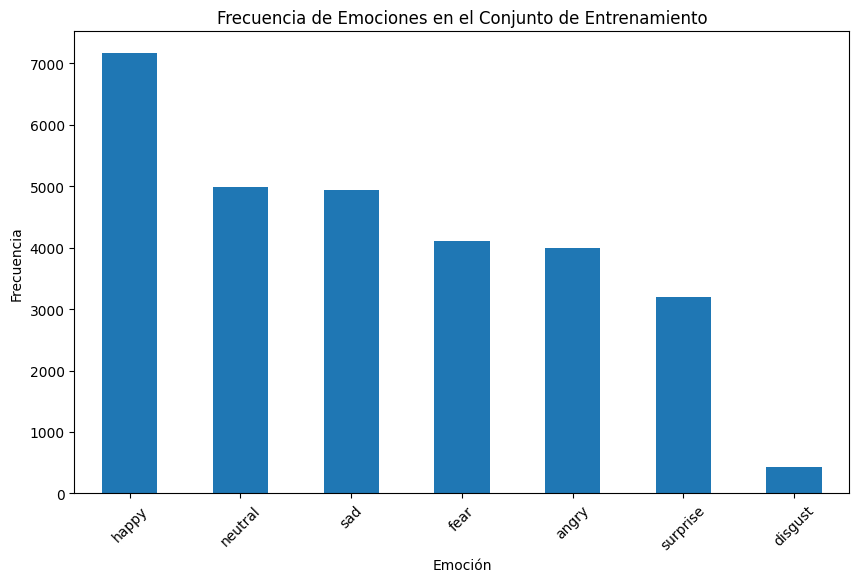

In [56]:
def count_emotions(csv_path):
    data = read_csv(csv_path)
    emotion_counts = data.iloc[:, 2].value_counts()
    return emotion_counts

# Contar las frecuencias de cada emoción en el conjunto de entrenamiento
emotion_counts = count_emotions(csv_path)
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Frecuencia de Emociones en el Conjunto de Entrenamiento')
plt.xlabel('Emoción')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

### Las clases estan desbalanceadas

In [57]:
# Expandir dimensiones para incluir el canal de color
train_images = np.expand_dims(train_images, -1)

# Train test split

In [58]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels.argmax(axis=1))

### Corregimos las clases desbalanceadas

In [59]:
# Calcular los pesos de clase
numeric_labels = encode_labels([label_encoder.inverse_transform([np.argmax(label)])[0] for label in train_labels])
class_weights = compute_class_weight('balanced', classes=np.unique(numeric_labels), y=numeric_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(emotions))}

In [60]:
# Generador de datos con aumentación
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_images)

# Modelo

In [64]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(emotions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) // 32,
          epochs=100,
          class_weight=class_weight_dict,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping, model_checkpoint])

model.save('primer_modelo.keras') #Para guardar el modelo

Epoch 1/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 231s 316ms/step - accuracy: 0.1391 - loss: 12.4861 - val_accuracy: 0.1112 - val_loss: 2.5641
Epoch 2/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.0938 - loss: 2.2469 - val_accuracy: 0.1112 - val_loss: 2.5614
Epoch 3/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 237s 329ms/step - accuracy: 0.1477 - loss: 2.2900 - val_accuracy: 0.2045 - val_loss: 1.9675
Epoch 4/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.2188 - loss: 1.7064 - val_accuracy: 0.2116 - val_loss: 1.9653
Epoch 5/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 258s 358ms/step - accuracy: 0.1369 - loss: 2.0617 - val_accuracy: 0.0800 - val_loss: 1.9648
Epoch 6/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.1250 - loss: 1.6461 - val_accuracy: 0.0827 - val_loss: 1.9643
Epoch 7/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 261s 362ms/step - accuracy: 0.1525 - loss: 1.9563 - val_accuracy: 0.1861 - val_loss: 1.9231
Epoch 8/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.0938 

# Cargamos el modelo

In [103]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('best_model.keras')

In [104]:
test_csv_path = './data/test_set.csv'  # Asegúrate de tener un CSV similar para el test set
test_base_path = './data/images/test'

In [105]:
def load_test_images_from_csv(csv_path, base_path):
    ids = read_csv(csv_path)
    images = []
    identificacion=[]

    for _, row in ids.iterrows():
        img_path = base_path+'/' + str(row[0])+'.jpg'
        image_id = row[0]  
        
        with Image.open(img_path) as img:
            img = img.convert('L')
            images.append(np.array(img))
            identificacion.append(image_id)
    
    return images, ids

In [106]:
test_images, test_ids = load_test_images_from_csv(test_csv_path, test_base_path)
test_images = normalize_images(test_images)
test_images = np.expand_dims(test_images, -1)

In [107]:
# Hacer predicciones
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step


In [108]:
output_df = pd.DataFrame({'id_img': test_ids['id_img'], 'label': predicted_labels})

In [109]:
output_df

,id_img,label
0,10052,sad
1,10065,sad
2,10079,surprise
3,10095,sad
4,10121,sad
...,...,...
7061,9806,angry
7062,9830,sad
7063,9853,sad
7064,9878,neutral


In [102]:
output_df.to_csv('submision1.csv', index=False)

# Resultado:  0.18966

# Segundo Intento

In [4]:
from funciones import *

In [11]:
csv_path = './data/train_set.csv'
base_path = './data/images/train'

In [12]:
train_images, train_labels = load_images_from_csv(csv_path, base_path)

# Split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

In [14]:
pd.DataFrame(y_train).value_counts()

0       
happy       5731
neutral     3986
sad         3950
fear        3282
angry       3194
surprise    2564
disgust      349
Name: count, dtype: int64

In [15]:
df=pd.DataFrame({'imagen':X_train,'id': y_train})

In [16]:
import random

# Happy

In [17]:
imagenes_happy=df[df['id']=='happy'].sample(n=4000)

# Neutral     

In [18]:
imagenes_neutral=df[df['id']=='neutral'].sample(n=3986)
for i in range(4000-3986):
    nuevo=df[df['id']=='neutral'].sample(n=1)
    imagenes_neutral=pd.concat([imagenes_neutral,nuevo],ignore_index=True)

# Sad

In [19]:
imagenes_sad=df[df['id']=='sad'].sample(n=3950)
for i in range(4000-3950):
    nuevo=df[df['id']=='sad'].sample(n=1)
    imagenes_sad=pd.concat([imagenes_sad,nuevo],ignore_index=True)

# Fear

In [20]:
imagenes_fear=df[df['id']=='fear'].sample(n=3282)
for i in range(4000-3282):
    nuevo=df[df['id']=='fear'].sample(n=1)
    imagenes_fear=pd.concat([imagenes_fear,nuevo],ignore_index=True)

# Angry

In [21]:
imagenes_angry=df[df['id']=='angry'].sample(n=3194)
for i in range(4000-3194):
    nuevo=df[df['id']=='angry'].sample(n=1)
    imagenes_angry=pd.concat([imagenes_angry,nuevo],ignore_index=True)

# Surprise

In [22]:
imagenes_surprise=df[df['id']=='surprise'].sample(n=2564)
for i in range(4000-2564):
    nuevo=df[df['id']=='surprise'].sample(n=1)
    imagenes_surprise=pd.concat([imagenes_surprise,nuevo],ignore_index=True)

# Disgust

In [23]:
imagenes_disgust=df[df['id']=='disgust'].sample(n=349)
for i in range(4000-349):
    nuevo=df[df['id']=='disgust'].sample(n=1)
    imagenes_disgust=pd.concat([imagenes_disgust,nuevo],ignore_index=True)

In [24]:
df_train=pd.concat([imagenes_angry,imagenes_sad,imagenes_happy,imagenes_neutral,imagenes_fear,imagenes_disgust,imagenes_surprise],ignore_index=True)

In [25]:
df_train['imagen']=df_train['imagen']/255

In [26]:
pd.get_dummies(df_train, columns=['id']).columns

Index(['imagen', 'id_angry', 'id_disgust', 'id_fear', 'id_happy', 'id_neutral',
       'id_sad', 'id_surprise'],
      dtype='object')

In [27]:
X_train[0].shape

(48, 48)

In [28]:
X_train=np.stack(df_train['imagen'])
y_train=pd.get_dummies(df_train, columns=['id'])[['id_angry', 'id_disgust', 'id_fear', 'id_happy', 'id_neutral','id_sad', 'id_surprise']]

In [29]:
X_val=np.array(X_val)/255
y_val=pd.get_dummies(y_val, columns=['id'])

In [30]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(28000, 48, 48) (5765, 48, 48) (28000, 7) (5765, 7)


# Modelo

In [154]:
model = Sequential([
    Conv2D(32, (3, 3), activation='sigmoid', input_shape=(48, 48, 1), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='sigmoid', kernel_initializer='he_uniform'),
    Dense(7, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('segundo_modelo_check.keras', monitor='val_loss', save_best_only=True)

model.fit(X_train, y_train, 
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 71s 78ms/step - accuracy: 0.2749 - loss: 1.8437 - val_accuracy: 0.4184 - val_loss: 1.4771
Epoch 2/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.5259 - loss: 1.2208 - val_accuracy: 0.4850 - val_loss: 1.3562
Epoch 3/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.5931 - loss: 1.0523 - val_accuracy: 0.4925 - val_loss: 1.3328
Epoch 4/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.6436 - loss: 0.9259 - val_accuracy: 0.5138 - val_loss: 1.3657
Epoch 5/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/step - accuracy: 0.6950 - loss: 0.8103 - val_accuracy: 0.5006 - val_loss: 1.4419
Epoch 6/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.7344 - loss: 0.7108 - val_accuracy: 0.5261 - val_loss: 1.4237
Epoch 7/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.7692 - loss: 0.6207 - val_accuracy: 0.5204 - val_loss: 1.5295
Epoch 8/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.8034 - loss: 0

# Cargamos el modelo

In [160]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('segundo_modelo_check.keras')

In [161]:
test_csv_path = './data/test_set.csv'  
test_base_path = './data/images/test'

In [162]:
def load_test_images_from_csv(csv_path, base_path):
    ids = read_csv(csv_path)
    images = []
    identificacion=[]

    for _, row in ids.iterrows():
        img_path = base_path+'/' + str(row[0])+'.jpg'
        image_id = row[0]  
        
        with Image.open(img_path) as img:
            img = img.convert('L')
            images.append(np.array(img))
            identificacion.append(image_id)
    
    return images, ids

test_images, test_ids = load_test_images_from_csv(test_csv_path, test_base_path)
test_images = normalize_images(test_images)
test_images = np.expand_dims(test_images, -1)

# Hacer predicciones
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

output_df = pd.DataFrame({'id_img': test_ids['id_img'], 'label': predicted_labels})
output_df

221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step


,id_img,label
0,10052,sad
1,10065,sad
2,10079,fear
3,10095,angry
4,10121,angry
...,...,...
7061,9806,surprise
7062,9830,sad
7063,9853,surprise
7064,9878,neutral


In [159]:
output_df.to_csv('submision2.csv', index=False)

# Resultado: 0.48

# Tercer modelo

In [32]:
model = Sequential([
    Conv2D(32, (3, 3), activation='sigmoid', input_shape=(48, 48, 1), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='sigmoid', kernel_initializer='he_uniform'),
    Dense(7, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('tercer_modelo.keras', monitor='val_loss', save_best_only=True)

model.fit(X_train, y_train, 
                    batch_size=32,
                    steps_per_epoch=1000,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 67ms/step - accuracy: 0.2915 - loss: 1.7989 - val_accuracy: 0.4002 - val_loss: 1.6985
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.5317 - loss: 1.2124 - val_accuracy: 0.4593 - val_loss: 1.4425
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.6024 - loss: 1.0378 - val_accuracy: 0.4774 - val_loss: 1.3985
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 70ms/step - accuracy: 0.6499 - loss: 0.9167 - val_accuracy: 0.5124 - val_loss: 1.3153
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.6875 - loss: 0.8163 - val_accuracy: 0.5154 - val_loss: 1.4343
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.7272 - loss: 0.7250 - val_accuracy: 0.5105 - val_loss: 1.4606
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.7604 - loss: 0.6394 - val_accuracy: 0.5480 - val_loss: 1.4706
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 

# Cargamos el modelo

In [35]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('tercer_modelo.keras')

test_csv_path = './data/test_set.csv'  
test_base_path = './data/images/test'

def load_test_images_from_csv(csv_path, base_path):
    ids = read_csv(csv_path)
    images = []
    identificacion=[]

    for _, row in ids.iterrows():
        img_path = base_path+'/' + str(row[0])+'.jpg'
        image_id = row[0]  
        
        with Image.open(img_path) as img:
            img = img.convert('L')
            images.append(np.array(img))
            identificacion.append(image_id)
    
    return images, ids

test_images, test_ids = load_test_images_from_csv(test_csv_path, test_base_path)
test_images = normalize_images(test_images)
test_images = np.expand_dims(test_images, -1)

# Hacer predicciones
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

output_df = pd.DataFrame({'id_img': test_ids['id_img'], 'label': predicted_labels})
output_df

221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step


,id_img,label
0,10052,neutral
1,10065,sad
2,10079,angry
3,10095,angry
4,10121,angry
...,...,...
7061,9806,surprise
7062,9830,happy
7063,9853,surprise
7064,9878,surprise


In [36]:
output_df.to_csv('submision3.csv', index=False)

# Resultado: 0.52052

# Cuarta Prueba

In [10]:
csv_path = './data/train_set.csv'
base_path = './data/images/train'
train_images, train_labels = load_images_from_csv(csv_path, base_path)
train_images, train_labels = preprocess_data(train_images, train_labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42)
# Calcular los pesos de clase
numeric_labels = encode_labels([label_encoder.inverse_transform([np.argmax(label)])[0] for label in train_labels])
class_weights = compute_class_weight('balanced', classes=np.unique(numeric_labels), y=numeric_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(emotions))}

In [11]:
class_weight_dict

{0: 1.031125898894494,
 1: 9.443315858453474,
 2: 1.0034817729187702,
 3: 0.5747188322565207,
 4: 0.8264322991340254,
 5: 0.8337962159347335,
 6: 1.2846445286382884}

In [15]:
X_train=np.array(X_train)

In [19]:
X_val=np.array(X_val)

In [16]:
X_train.shape

(23056, 48, 48)

In [20]:

model = Sequential([
    Conv2D(32, (3, 3), activation='sigmoid', input_shape=(48, 48, 1), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='sigmoid', kernel_initializer='he_uniform'),
    Dense(7, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cuarto_modelo.keras', monitor='val_loss', save_best_only=True)

model.fit(X_train, y_train, 
                    class_weight=class_weight_dict,
                    batch_size=32,
                    steps_per_epoch=1000,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 60ms/step - accuracy: 0.2368 - loss: 1.9726 - val_accuracy: 0.2486 - val_loss: 1.8865
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.3857 - loss: 1.5805 - val_accuracy: 0.3984 - val_loss: 1.6135
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.4552 - loss: 1.4056 - val_accuracy: 0.4234 - val_loss: 1.4275
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - accuracy: 0.4961 - loss: 1.2817 - val_accuracy: 0.4656 - val_loss: 1.3900
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 66ms/step - accuracy: 0.5220 - loss: 1.1979 - val_accuracy: 0.4982 - val_loss: 1.3664
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.5499 - loss: 1.1197 - val_accuracy: 0.5084 - val_loss: 1.3216
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 74s 74ms/step - accuracy: 0.5802 - loss: 1.0346 - val_accuracy: 0.5256 - val_loss: 1.2803
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 

In [21]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('tercer_modelo.keras')

test_csv_path = './data/test_set.csv'  
test_base_path = './data/images/test'

def load_test_images_from_csv(csv_path, base_path):
    ids = read_csv(csv_path)
    images = []
    identificacion=[]

    for _, row in ids.iterrows():
        img_path = base_path+'/' + str(row[0])+'.jpg'
        image_id = row[0]  
        
        with Image.open(img_path) as img:
            img = img.convert('L')
            images.append(np.array(img))
            identificacion.append(image_id)
    
    return images, ids

test_images, test_ids = load_test_images_from_csv(test_csv_path, test_base_path)
test_images = normalize_images(test_images)
test_images = np.expand_dims(test_images, -1)

# Hacer predicciones
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

output_df = pd.DataFrame({'id_img': test_ids['id_img'], 'label': predicted_labels})
output_df

221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


,id_img,label
0,10052,neutral
1,10065,sad
2,10079,angry
3,10095,angry
4,10121,disgust
...,...,...
7061,9806,surprise
7062,9830,surprise
7063,9853,surprise
7064,9878,happy


In [22]:
output_df.to_csv('submision4.csv', index=False)